# Project title: classification of fruits and vegetables with neural network


The big idea of program is recogniseing fruits and vegetables in pictures. I have prepared and trained few CNN models. The study contains full code in Python and shows result of work.
It works in following schema:

* Python packages imports and functions definitons
* data proprocessing and model compiling
* CNN model training
* model's test
* plot of training hisory
* prediction on new picture using best model
    
I used for training `Fruits-360 data set` delineated in paper `Horea Muresan, Mihai Oltean: "Fruit recognition from images using deep learning", Technical Report, Babes-Bolyai University, 2017`

# Imports

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow backend
import tensorflow as tf

from keras import models, layers, regularizers
#from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, History
from keras.regularizers import l2
# optimizers
from keras.optimizers import RMSprop, Adam

from sklearn.metrics import accuracy_score, confusion_matrix
from itertools import product
from IPython.display import Image

Using TensorFlow backend.


# Functions and global parameters

In [57]:
def get_path(out):
    """Sets up given to input path as current working dir. and returns it as variable"""
    print(out)
    path = input()
    os.chdir(path)
    return (path)
    
    
    
def get_model():
    """ Gets a path to directory, and returs pointed model"""        
    get_path("Podaj ścieżkę do folderu z modelem: ")
    !ls
    model = input("Wybierz plik modelu: ")
    model_opn = models.load_model(model)
    return model_opn



def model_training(model, early_stop):
    ''' Function trains model by fit_generator
    Variables: model - compiled model, callbacks. Saves trained model and returns training history
    '''
    model_name = input("Podaj nazwę modelu: ")
    train_datagen.reset()
    history = model.fit_generator(train_datagen,
                                    steps_per_epoch=nb_train_samples/batch_size,
                                    validation_data=valid_datagen,
                                    validation_steps=nb_valid_samples,
                                    callbacks=[early_stop],
                                    epochs=100)
    model.save(model_name)
    return model, history, model_name



def model_test(model_name, test_data_generator, steps):
    '''
    Function testes model with data generator
    Variables: model - compiled model, test. Saves trained model and returns training history
    '''
    _model_name = model_name
    _steps = steps
    
    print('\n')
    print('****************  ' + model_name + '  ****************')
    model = models.load_model(_model_name)
    
    # REMEMBER TO RESET GENERATOR BEFORE NEXT USE
    test_datagen.reset()
    
    #STEPS: no. of batches from generator
    test_preds = model.predict_generator(test_datagen, steps=_steps) 
    test_clas = test_datagen.classes
    
    model_result =[]
    model_result.append(model.evaluate_generator(test_datagen, steps=3))
    print('Metrics: ' + str(model.metrics_names))
    print('Model metrics value: ' + str(model_result))
    return model_result



def history_plot(history, model_name):
    '''
    Plots traing history
    Variables: training history, model name
    '''
    # accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='lower right')#upper left
    plt.savefig(model_name + '_acc')
    plt.show()
    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper right')
    plt.savefig(model_name + '_loss')
    plt.show()
    

    
def prediction(model_path, model_name, pic_path, pic_name):
    
    """Function makes prediction on a single image;
    Params: model_path - path to CNN keras model, model_name - name of CNN model,
            pic_path - path to image, pic_name - name of image
    Return: prediction result
    """
    
    _model_path = model_path
    _model_name = model_name
    _pic_path = pic_path
    _pic_name = pic_name

    os.chdir(_model_path)
    model_opn = models.load_model(_model_name)
    print('\n')
    print('*************  ' + _model_path + '/' + _model_name + '  is loaded! *************')

    os.chdir(_pic_path)
    pred_img = load_img(_pic_name)

    pred_np = img_to_array(pred_img)/255
    pred_np = np.expand_dims(pred_np, axis=0)

    predict_img = tf.image.resize_images(pred_np, (100,100))
    preds = model_opn.predict(predict_img, steps=1)
    print(preds)
    
    return preds, pred_img
    

## Global parameters

In [15]:
# the tuple contains target picture size: width x height

target_size = (100,100)

# paths to data set
train_path = '/home/marcin/Projects/Dyplomowy/Training'
valid_path = '/home/marcin/Projects/Dyplomowy/Validation'
test_path = '/home/marcin/Projects/Dyplomowy/Test'

# batch size & seed
batch_size = 32
seed = 42

# Data preprocessing

It prepares sets of images for Training, Validation and Test

In [53]:
# ImageDataGenerator to upload and augment data from folders

train_idg = ImageDataGenerator(rescale=1./255,
                               rotation_range=45,
                               vertical_flip=True,
                               horizontal_flip=True,
                               brightness_range=[0.7, 1.0],
                               fill_mode='nearest',
                               dtype='float32')    

valid_idg = ImageDataGenerator(rescale=1./255, dtype='float32')

test_idg = ImageDataGenerator(rescale=1./255, dtype='float32')


# training/test data gen: takes the path to a directory and generates batches of augmented data

train_datagen= train_idg.flow_from_directory(train_path,
                                                target_size=target_size,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed)

valid_datagen = valid_idg.flow_from_directory(valid_path,
                                                target_size=target_size,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=seed)

test_datagen = test_idg.flow_from_directory(test_path,
                                            target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False,
                                            seed=seed)
# numbers of train/valid/test samples

nb_train_samples = len(train_datagen.filenames)
nb_valid_samples = len(valid_datagen.filenames)
nb_test_samples = len(test_datagen.filenames)

# shows classes labels

train_datagen.class_indices

Found 5440 images belonging to 11 classes.
Found 1822 images belonging to 11 classes.
Found 1822 images belonging to 11 classes.


{'Apple Granny Smith': 0,
 'Apple Red': 1,
 'Avocado': 2,
 'Banana': 3,
 'Kiwi': 4,
 'Lemon': 5,
 'Onion White': 6,
 'Orange': 7,
 'Potato White': 8,
 'Tomato': 9,
 'Walnut': 10}

# Model part

## CNN model definition

Defining, compiling and trainig single CNN model

In [6]:
model = Sequential()

model.add(Conv2D(128, kernel_size=3,strides=(2,2), activation="relu", padding='same', input_shape=(target_size[0], target_size[1], 3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(64, kernel_size=3,strides=(2,2), activation="relu", padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(32, kernel_size=3,strides=(2,2), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(11,activation="softmax")) # 11- numer of classes

model.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["categorical_accuracy"], )

model.summary()

W0219 17:10:42.113121 139773629794112 deprecation_wrapper.py:119] From /home/marcin/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0219 17:10:42.356759 139773629794112 deprecation_wrapper.py:119] From /home/marcin/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0219 17:10:42.461789 139773629794112 deprecation_wrapper.py:119] From /home/marcin/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0219 17:10:42.546693 139773629794112 deprecation_wrapper.py:119] From /home/marcin/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0219 17:10:42.5906

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 128)       3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 32)          18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 32)          0         
__________

In [7]:
# Callbacks

early_stop = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

# runs compiling and training definied model

compiled_model = model
trained_model, history, model_name = model_training(compiled_model, early_stop)

Podaj nazwę modelu: model_mix51


W0219 17:12:02.805696 139773629794112 deprecation.py:323] From /home/marcin/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
170/170 [==============================] - 81s 476ms/step - loss: 1.5838 - categorical_accuracy: 0.4031 - val_loss: 0.6875 - val_categorical_accuracy: 0.7662
Epoch 2/100
170/170 [==============================] - 41s 244ms/step - loss: 0.7571 - categorical_accuracy: 0.7140 - val_loss: 0.4435 - val_categorical_accuracy: 0.8928
Epoch 3/100
170/170 [==============================] - 42s 249ms/step - loss: 0.5175 - categorical_accuracy: 0.8066 - val_loss: 0.2940 - val_categorical_accuracy: 0.8764
Epoch 4/100
170/170 [==============================] - 42s 246ms/step - loss: 0.4332 - categorical_accuracy: 0.8349 - val_loss: 0.2434 - val_categorical_accuracy: 0.9045
Epoch 5/100
170/170 [==============================] - 42s 250ms/step - loss: 0.3614 - categorical_accuracy: 0.8664 - val_loss: 0.2142 - val_categorical_accuracy: 0.9076
Epoch 6/100
170/170 [==============================] - 45s 264ms/step - loss: 0.3190 - categorical_accuracy: 0.8774 - val_loss: 0.2398 - val_categoric

## Training history plot
`history_plot` function plots history of training process

Below prodecure that change `history.history` to Pandas DF and saves to `csv` file

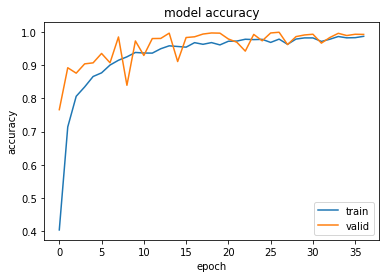

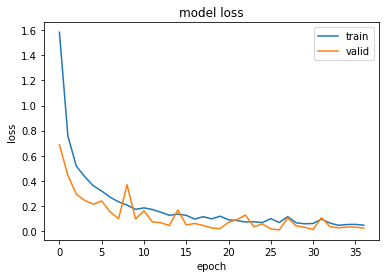

In [8]:
history_plot(history, model_name)

In [9]:
# saves history in model_name.csv     
hist_df = pd.DataFrame(history.history) 
hist_csv_file = model_name + '.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Tests part
Model accuracy on `test` set

In [30]:
test = model_test(model_name, test_datagen, nb_test_samples/batch_size)



****************  model_mix51  ****************
Metrics: ['loss', 'categorical_accuracy']
Model metrics value: [[1.4396070583413187, 0.7291666666666666]]



## Prediction on image out of dataset

Function `prediction()` returns numpy array of prediction and shows image




*************  /home/marcin/Projects/Dyplomowy/Models_best/model_mix51  is loaded! *************
[[2.9613434e-24 1.0000000e+00 7.0131218e-18 9.6135391e-22 1.7464871e-10
  2.0916653e-23 1.5545893e-08 2.6361400e-09 3.1748890e-24 2.3443107e-08
  3.0038704e-33]]


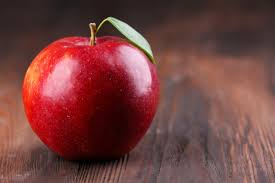

In [58]:
model_path = '/home/marcin/Projects/Dyplomowy/Models_best'
model_name = 'model_mix51'
pic_path = '/home/marcin/Projects/Dyplomowy'
pic_name = 'jablko2.jpeg'

preds, img = prediction(model_path, model_name, pic_path, pic_name)
img